
Accuracy: 0.4550
F1 Score: 0.3768
Recall:   0.4550
Precision:0.4805


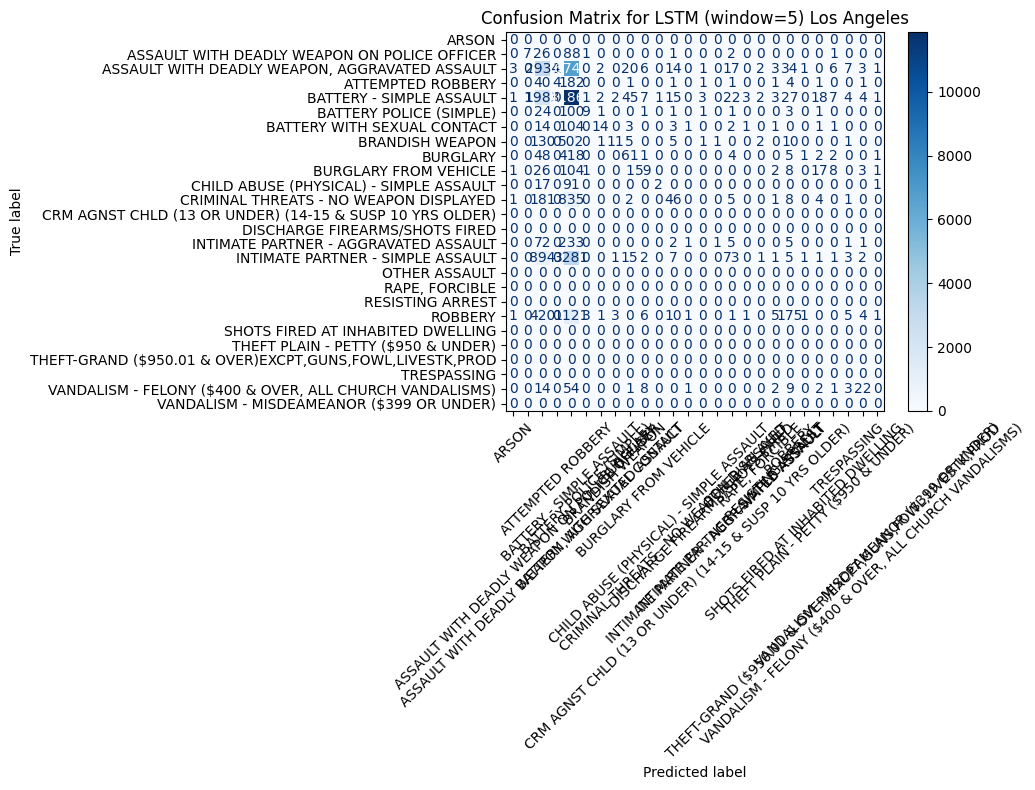

In [ ]:
import numpy as np
import pandas as pd
import torch
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import warnings

from torch.utils.data import DataLoader, Dataset

warnings.filterwarnings('ignore')

# === PyTorch Dataset Sınıfı ===
class CrimeDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# === Model Sınıfı ===
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1, dropout=0.3):
        super(LSTMClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x: (B, T, F)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)

        out, _ = self.lstm(x, (h0, c0))  # out: (B, T, H)
        out = out[:, -1, :]              # son zaman adımının çıktısı → (B, H)
        out = self.fc(out)              # (B, output_dim)
        return out

# === Test için Yükleme Ayarları ===

window_size = 5  # Pencere büyüklüğünü 5 olarak seçelim
model_path = f"model_rnn_k{window_size}_la.pt"
scaler_path = f"scaler_rnn_k{window_size}_la.pkl"
encoder_path = f"label_encoder_rnn_k{window_size}_la.pkl"

# === Veriyi Yükle ve Sekans Oluştur ===
la_df = pd.read_csv("Crime_Data_from_2020_to_Present.csv")
def build_daily_summary_rnn(df, top_k_values=5):
    

    df = df.copy()

    # Tarihi normalleştir
    df['DATE OCC'] = pd.to_datetime(df['DATE OCC'], errors='coerce')
    df['day'] = df['DATE OCC'].dt.date
    df['hour'] = df['DATE OCC'].dt.hour

    # Eksik değerleri dolduralım (gerekirse daha ileri imputation yapılabilir)
    df['Vict Age'] = df['Vict Age'].fillna(df['Vict Age'].median())
    for col in ['Vict Sex', 'Vict Descent', 'Premis Desc', 'Weapon Desc']:
        df[col] = df[col].fillna("UNKNOWN")

    grouped = df.groupby(['AREA NAME', 'day'])
    daily_features = []

    # Histogram kategorilerini kısıtlamak için en sık görülen kategoriler
    top_categories = {
        col: df[col].value_counts().nlargest(top_k_values).index.tolist()
        for col in ['Vict Sex', 'Vict Descent', 'Premis Desc', 'Weapon Desc']
    }

    for (area, day), group in grouped:
        summary = {
            'AREA NAME': area,
            'DAY': day,
            'Vict_Age_Mean': group['Vict Age'].mean(),
            'Vict_Age_Max': group['Vict Age'].max(),
            'Crime_Count': len(group),
        }

        # Saat histogramı (0-23)
        hour_counts = group['hour'].value_counts(normalize=True)
        for h in range(24):
            summary[f'Hour_{h}'] = hour_counts.get(h, 0.0)

        # Kategorik histogramlar (ilk top_k değer için)
        for col in ['Vict Sex', 'Vict Descent', 'Premis Desc', 'Weapon Desc']:
            counts = group[col].value_counts(normalize=True)
            for val in top_categories[col]:
                summary[f"{col}_{val}"] = counts.get(val, 0.0)

        # Etiket (o günün baskın suç türü)
        mode_crime = group['Crm Cd Desc'].mode()
        summary['Crime_Mode'] = mode_crime[0] if not mode_crime.empty else None

        daily_features.append(summary)

    return pd.DataFrame(daily_features)


#from feature_building import build_daily_summary_la
daily_df = build_daily_summary_rnn(la_df)
value_counts = daily_df['Crime_Mode'].value_counts()
valid_classes = value_counts[value_counts >= 100].index
daily_df = daily_df[daily_df['Crime_Mode'].isin(valid_classes)]

def create_sequences_rnn(daily_df, window_size=5, feature_cols=None):
    
    # Ihtiyac duyulabilir
    from collections import defaultdict
    

    data = []
    labels = []

    # Özellik sütunlarını belirle (DAY, AREA NAME ve Crime_Mode hariç) (Feature Cols kısmı opsiyonel bu kısımda zaman verileriyle çalıştık, ihtiyaç duyulabilir ama modifikasyon gerekir)
    if feature_cols is None:
        exclude = ['AREA NAME', 'DAY', 'Crime_Mode']
        feature_cols = [col for col in daily_df.columns if col not in exclude]

    # Tüm konumlar için sırayla işle
    grouped = daily_df.groupby('AREA NAME')

    for area, group in grouped:
        group = group.sort_values(by='DAY').reset_index(drop=True)

        for i in range(len(group) - window_size):
            window = group.iloc[i:i+window_size]
            target_day = group.iloc[i+window_size]

            # Eksik etiket varsa atla
            if pd.isnull(target_day['Crime_Mode']):
                continue

            # X: (t, f) dizisi
            x_seq = window[feature_cols].values.astype(np.float32)
            y_label = target_day['Crime_Mode']

            data.append(x_seq)
            labels.append(y_label)

    return np.array(data), np.array(labels), feature_cols
X, y, feature_cols = create_sequences_rnn(daily_df, window_size=window_size)

# Scaler ve Encoder'ları yükle
scaler = joblib.load(scaler_path)
le = joblib.load(encoder_path)

# Preprocess (Test dosyasında scaler/encoder yeniden fit edilmez!)
n, t, f = X.shape
X_reshaped = X.reshape(-1, f)
X_scaled = scaler.transform(X_reshaped).reshape(n, t, f)
y_encoded = le.transform(y)

# Dataset & DataLoader
test_dataset = CrimeDataset(X_scaled, y_encoded)
test_loader = DataLoader(test_dataset, batch_size=32)

# Modeli yükle
input_dim = X.shape[2]
output_dim = len(le.classes_)
model = LSTMClassifier(input_dim=input_dim, hidden_dim=128, output_dim=output_dim)
model.load_state_dict(torch.load(model_path))
model.eval()

# === Değerlendirme ===
y_true, y_pred = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(y_batch.numpy())
        y_pred.extend(predicted.numpy())

# === Metrikler ===
acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
rec = recall_score(y_true, y_pred, average='weighted')
prec = precision_score(y_true, y_pred, average='weighted')

print(f"\nAccuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Recall:   {rec:.4f}")
print(f"Precision:{prec:.4f}")

# === Confusion Matrix ===
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap="Blues", ax=plt.gca(), xticks_rotation=45)
plt.title(f"Confusion Matrix for LSTM (window={window_size}) Los Angeles")
plt.tight_layout()
plt.show()